In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip -q install plyfile
PLY_PATH = "/content/drive/MyDrive/gaussplat_output/gs_ship_perfect/point_cloud/iteration_80000/point_cloud.ply"
import os
print("PLY path exists:", os.path.exists(PLY_PATH), "->", PLY_PATH)

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.7 MB/s eta 0:00:00
PLY path exists: True -> /content/drive/MyDrive/gaussplat_output/gs_ship_perfect/point_cloud/iteration_80000/point_cloud.ply


In [ ]:
from plyfile import PlyData
import numpy as np
import torch

ply = PlyData.read(PLY_PATH)
v = ply['vertex'].data
field_names = v.dtype.names
print("Vertex fields:", field_names)
first = v[0]
print("\nFirst vertex sample:")
for name in field_names[:20]:
    print(f"  {name}: {first[name]}")

Vertex fields: ('x', 'y', 'z', 'nx', 'ny', 'nz', 'f_dc_0', 'f_dc_1', 'f_dc_2', 'f_rest_0', 'f_rest_1', 'f_rest_2', 'f_rest_3', 'f_rest_4', 'f_rest_5', 'f_rest_6', 'f_rest_7', 'f_rest_8', 'f_rest_9', 'f_rest_10', 'f_rest_11', 'f_rest_12', 'f_rest_13', 'f_rest_14', 'f_rest_15', 'f_rest_16', 'f_rest_17', 'f_rest_18', 'f_rest_19', 'f_rest_20', 'f_rest_21', 'f_rest_22', 'f_rest_23', 'f_rest_24', 'f_rest_25', 'f_rest_26', 'f_rest_27', 'f_rest_28', 'f_rest_29', 'f_rest_30', 'f_rest_31', 'f_rest_32', 'f_rest_33', 'f_rest_34', 'f_rest_35', 'f_rest_36', 'f_rest_37', 'f_rest_38', 'f_rest_39', 'f_rest_40', 'f_rest_41', 'f_rest_42', 'f_rest_43', 'f_rest_44', 'f_rest_45', 'f_rest_46', 'f_rest_47', 'f_rest_48', 'f_rest_49', 'f_rest_50', 'f_rest_51', 'f_rest_52', 'f_rest_53', 'f_rest_54', 'f_rest_55', 'f_rest_56', 'f_rest_57', 'f_rest_58', 'f_rest_59', 'f_rest_60', 'f_rest_61', 'f_rest_62', 'f_rest_63', 'f_rest_64', 'f_rest_65', 'f_rest_66', 'f_rest_67', 'f_rest_68', 'f_rest_69', 'f_rest_70', 'f_rest_

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def np_field_to_torch(v, names, device):
    arr = np.stack([v[n] for n in names], axis=1).astype(np.float32)
    return torch.from_numpy(arr).to(device)


pos = np_field_to_torch(v, ['x','y','z'], device)
N = pos.shape[0]
f_dc = np_field_to_torch(v, ['f_dc_0','f_dc_1','f_dc_2'], device)
colors = torch.sigmoid(f_dc)
opacity = torch.from_numpy(np.array(v['opacity'], dtype=np.float32)).to(device)
scales_log = np_field_to_torch(v, ['scale_0','scale_1','scale_2'], device)
scales = torch.exp(scales_log)
rot = np_field_to_torch(v, ['rot_0','rot_1','rot_2','rot_3'], device)
MAX_N = 40000
if MAX_N is not None and N > MAX_N:
    idx = torch.randperm(N, device=device)[:MAX_N]
    pos, colors, opacity, scales, rot = pos[idx], colors[idx], opacity[idx], scales[idx], rot[idx]
    N = pos.shape[0]

print(f"Loaded splats: {N}")
print("pos:", pos.shape, "colors:", colors.shape, "opacity:", opacity.shape, "scales:", scales.shape, "rot:", rot.shape)
print("pos xyz min/max:", pos.min(dim=0).values.tolist(), pos.max(dim=0).values.tolist())
print("opacity min/max:", float(opacity.min()), float(opacity.max()))
print("colors mean:", colors.mean(dim=0).tolist())

Loaded splats: 40000
pos: torch.Size([40000, 3]) colors: torch.Size([40000, 3]) opacity: torch.Size([40000]) scales: torch.Size([40000, 3]) rot: torch.Size([40000, 4])
pos xyz min/max: [-3.2601287364959717, -2.5433318614959717, -1.4855890274047852] [3.430394411087036, 2.944934844970703, 1.7498927116394043]
opacity min/max: -7.037564277648926 18.052099227905273
colors mean: [0.4453704059123993, 0.4266367554664612, 0.38483890891075134]


In [ ]:
import math

def pinhole_intrinsics(fov_deg, W, H):
    f = 0.5 * W / math.tan(0.5 * math.radians(fov_deg))
    K = torch.tensor([[f, 0, W/2],
                      [0, f, H/2],
                      [0, 0,   1 ]], dtype=torch.float32, device=pos.device)
    return K, f

def look_at(eye, center, up=torch.tensor([0.,1.,0.])):
    eye, center, up = [torch.tensor(v, dtype=torch.float32, device=pos.device) for v in (eye, center, up)]
    z = (center - eye); z = z / torch.norm(z)
    x = torch.cross(z, up); x = x / torch.norm(x)
    y = torch.cross(x, z)
    R = torch.stack([x, y, z], dim=0)
    t = -R @ eye
    return R, t

def project_points(pts, K, R, t):
    Xc = (R @ pts.T + t[:, None]).T
    z = Xc[:, 2]
    eps = 1e-6
    zsafe = torch.clamp(z, min=eps)
    Xn = Xc / zsafe[:, None]
    uv_h = (K @ Xn.T).T
    uv = uv_h[:, :2]
    return uv, z

K, f = pinhole_intrinsics(60, W, H)
R, t = look_at([0,0,-2.5], [0,0,0])
uv_test, z_test = project_points(pos, K, R, t)
in_front = (z_test > 0).sum().item()
in_img  = ((uv_test[:,0] >= -50) & (uv_test[:,0] <= W+50) & (uv_test[:,1] >= -50) & (uv_test[:,1] <= H+50)).sum().item()
print("In front:", in_front, "/", pos.shape[0], "| roughly in image (±50px):", in_img)

In front: 40000 / 40000 | roughly in image (±50px): 39504


/tmp/ipython-input-1431024466.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eye, center, up = [torch.tensor(v, dtype=torch.float32, device=pos.device) for v in (eye, center, up)]
/tmp/ipython-input-1431024466.py:16: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /pytorch/aten/src/ATen/native/Cross.cpp:63.)
  x = torch.cross(z, up); x = x / torch.norm(x)


In [ ]:
alpha = torch.sigmoid(opacity)
size3d = scales.mean(dim=1)
def radius_pixels_from_depth(size3d, z, focal_px, min_r=1.5, max_r=14.0):
    zsafe = torch.clamp(z, min=1e-3)
    r = size3d * (focal_px / zsafe)
    r = torch.clamp(r, min=min_r, max=max_r)
    return r

print("alpha range:", float(alpha.min()), float(alpha.max()))
print("size3d mean±std:", float(size3d.mean()), float(size3d.std()))

alpha range: 0.0008774925372563303 1.0
size3d mean±std: 0.005977238062769175 0.010776995681226254


/tmp/ipython-input-1431024466.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eye, center, up = [torch.tensor(v, dtype=torch.float32, device=pos.device) for v in (eye, center, up)]


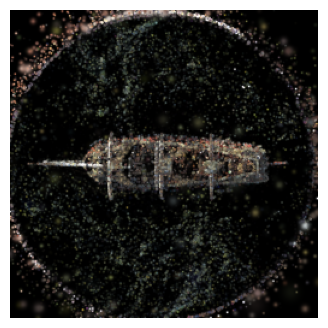

In [ ]:
import matplotlib.pyplot as plt

def render_gaussians_isotropic(uv, z, colors, alpha, radius_px, H, W):
    order = torch.argsort(z, descending=True)
    uv, z, colors, alpha, radius_px = [t[order] for t in (uv, z, colors, alpha, radius_px)]
    img = torch.zeros(H, W, 3, device=uv.device)
    acc = torch.zeros(H, W, device=uv.device)
    sigma = radius_px / 2.5
    N = uv.shape[0]
    for i in range(N):
        u, v = uv[i]
        if not (-50 <= u <= W+50 and -50 <= v <= H+50):
            continue
        s = float(sigma[i].clamp_min(0.5))
        r = int(3 * s)
        if r <= 0:
            continue
        u0, v0 = int(round(float(u))), int(round(float(v)))
        x0, x1 = max(0, u0 - r), min(W - 1, u0 + r)
        y0, y1 = max(0, v0 - r), min(H - 1, v0 + r)
        if x1 <= x0 or y1 <= y0:
            continue
        xs = torch.arange(x0, x1 + 1, device=uv.device)
        ys = torch.arange(y0, y1 + 1, device=uv.device)
        X, Y = torch.meshgrid(xs, ys, indexing='xy')
        w = torch.exp(-0.5 * (((X - u)**2 + (Y - v)**2) / (s * s)))
        a = alpha[i] * w
        region = img[y0:y1+1, x0:x1+1]
        region_acc = acc[y0:y1+1, x0:x1+1]
        contrib = (1.0 - region_acc).unsqueeze(-1) * a.unsqueeze(-1) * colors[i]
        img[y0:y1+1, x0:x1+1] = region + contrib
        acc[y0:y1+1, x0:x1+1] = region_acc + (1.0 - region_acc) * a
    return torch.clamp(img, 0.0, 1.0)

K, f = pinhole_intrinsics(60, W, H)
R, t = look_at([0,0,-2.5],[0,0,0])
uv, z = project_points(pos, K, R, t)
radius_px = radius_pixels_from_depth(size3d, torch.clamp(z, min=1e-3), f)
img = render_gaussians_isotropic(uv, z, colors, alpha, radius_px, H, W)

plt.figure(figsize=(4,4))
plt.imshow(img.detach().cpu().numpy())
plt.axis('off'); plt.show()

In [ ]:
from tqdm import trange
def orbit_camera(n_views=12, radius=2.5):
    cams = []
    for k in range(n_views):
        theta = 2*math.pi*k/n_views
        eye = [radius*math.sin(theta), 0.0, -radius*math.cos(theta)]
        R,t = look_at(eye,[0,0,0])
        cams.append((R,t))
    return cams

def splat_visibility_score(pos, size3d, alpha, K, f, R, t, H, W):
    uv, z = project_points(pos, K, R, t)
    r = radius_pixels_from_depth(size3d, torch.clamp(z,min=1e-3), f)
    score = alpha * (r**2) / (z**2 + 1e-6)
    mask = (z>0) & (uv[:,0]>-50) & (uv[:,0]<W+50) & (uv[:,1]>-50) & (uv[:,1]<H+50)
    score = torch.where(mask, score, torch.zeros_like(score))
    return score
cams = orbit_camera(n_views=12)
all_scores = []
for (R,t) in cams:
    score = splat_visibility_score(pos, size3d, alpha, K, f, R, t, H, W)
    all_scores.append(score.unsqueeze(1))

all_scores = torch.cat(all_scores, dim=1)
uncertainty = all_scores.std(dim=1)
print("Uncertainty stats: min", float(uncertainty.min()), "max", float(uncertainty.max()), "mean", float(uncertainty.mean()))

Uncertainty stats: min 0.0 max 2157.188720703125 mean 0.28277790546417236


/tmp/ipython-input-1431024466.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eye, center, up = [torch.tensor(v, dtype=torch.float32, device=pos.device) for v in (eye, center, up)]


/tmp/ipython-input-1971483927.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')
/tmp/ipython-input-1431024466.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eye, center, up = [torch.tensor(v, dtype=torch.float32, device=pos.device) for v in (eye, center, up)]


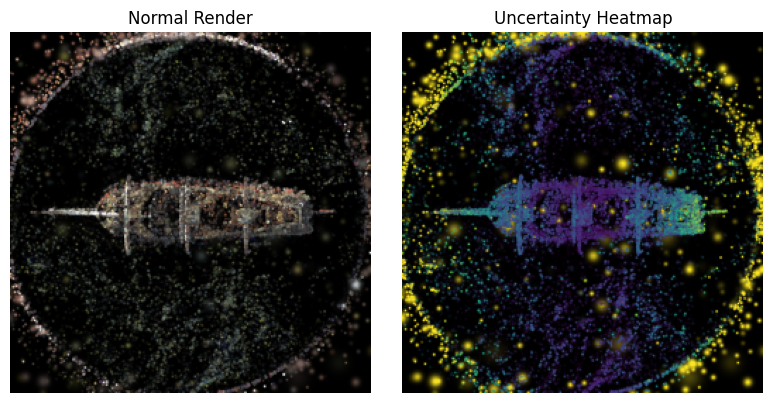

Uncertainty clipping percentiles: p5 = 0.0009118398884311318  p95 = 0.33651939034461975


In [ ]:
import matplotlib.pyplot as plt
u = uncertainty.detach()
p5  = torch.quantile(u, 0.05)
p95 = torch.quantile(u, 0.95)
u_norm = (u - p5) / (p95 - p5 + 1e-8)
u_norm = torch.clamp(u_norm, 0.0, 1.0)

import matplotlib
cmap = matplotlib.cm.get_cmap('viridis')
u_colors_np = cmap(u_norm.cpu().numpy())[:, :3]
u_colors = torch.from_numpy(u_colors_np).to(colors.device).float()
K, f = pinhole_intrinsics(60, W, H)
R, t = look_at([0,0,-2.5],[0,0,0])
uv, z = project_points(pos, K, R, t)
radius_px = radius_pixels_from_depth(size3d, torch.clamp(z,min=1e-3), f)
img_normal = render_gaussians_isotropic(uv, z, colors, alpha, radius_px, H, W)
img_heat   = render_gaussians_isotropic(uv, z, u_colors, alpha, radius_px, H, W)
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].imshow(img_normal.detach().cpu().numpy()); axs[0].set_title("Normal Render"); axs[0].axis('off')
axs[1].imshow(img_heat.detach().cpu().numpy());   axs[1].set_title("Uncertainty Heatmap"); axs[1].axis('off')
plt.tight_layout(); plt.show()

print("Uncertainty clipping percentiles: p5 =", float(p5), " p95 =", float(p95))

Mounted at /content/drive


  0%|          | 0/24 [00:00<?, ?it/s]/tmp/ipython-input-1431024466.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eye, center, up = [torch.tensor(v, dtype=torch.float32, device=pos.device) for v in (eye, center, up)]
100%|██████████| 24/24 [08:40<00:00, 21.70s/it]


Saved: /content/drive/MyDrive/gs_uncert_ship_normal.gif and /content/drive/MyDrive/gs_uncert_ship_heat.gif


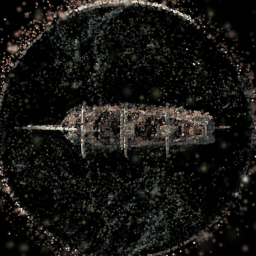

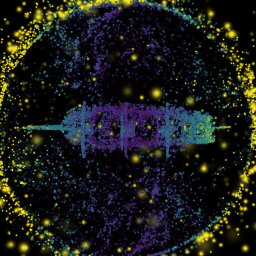

In [ ]:
import imageio.v2 as imageio
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

def render_view(R, t, color_tensor):
    uv, z = project_points(pos, K, R, t)
    radius_px = radius_pixels_from_depth(size3d, torch.clamp(z,min=1e-3), f)
    img = render_gaussians_isotropic(uv, z, color_tensor, alpha, radius_px, H, W).cpu().numpy()
    return (img*255).astype('uint8')
K, f = pinhole_intrinsics(60, W, H)
n_views = 24
radius = 2.5
normal_frames, heat_frames = [], []

for k in trange(n_views):
    theta = 2*math.pi*k/n_views
    eye = [radius*math.sin(theta), 0.0, -radius*math.cos(theta)]
    R, t = look_at(eye, [0,0,0])
    normal_frames.append(render_view(R, t, colors))
    heat_frames.append(render_view(R, t, u_colors))

normal_gif = "/content/drive/MyDrive/gs_uncert_ship_normal.gif"
heat_gif   = "/content/drive/MyDrive/gs_uncert_ship_heat.gif"
imageio.mimsave(normal_gif, normal_frames, duration=0.06)
imageio.mimsave(heat_gif,   heat_frames,   duration=0.06)
print("Saved:", normal_gif, "and", heat_gif)
from IPython.display import Image, display
display(Image(filename=normal_gif))
display(Image(filename=heat_gif))